## AirBnB Project - Linear Regression

# Airbnb Price Prediction Model

This notebook demonstrates the process of building and evaluating a machine learning model to predict Airbnb rental prices in New York City. The steps involved include:

1. **Data Loading and Exploration**: 
   - Importing the dataset and performing initial data exploration.
   - Handling missing values and encoding categorical variables.

2. **Feature Engineering**: 
   - Converting categorical variables into a one-hot encoded format.
   - Combining features into a suitable format for modeling.

3. **Model Development**:
   - Implementing a custom linear regression model using TensorFlow.
   - Creating and compiling a Keras model with dense layers for price prediction.

4. **Training and Evaluation**:
   - Training the model with the training dataset.
   - Evaluating the model's performance using test data.
   - Saving and loading the trained model for future use.

5. **Visualization**:
   - Generating visualizations to understand data distributions and correlations.
   - Displaying model performance metrics.

The goal of this analysis is to predict rental prices based on various features of the listings, using both a custom TensorFlow model and a Keras model. The notebook also includes visualizations to better understand the relationships between different features.

Let's dive into the data and start building our models!


#### Imports

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import warnings
# Suppress warnings to keep the output clean
warnings.filterwarnings('ignore')

#### Load Data and Take a Look at it

In [2]:
# Load the dataset and shuffle it randomly
data = pd.read_csv('data/AB_NYC_2019.csv').sample(frac=1) #randomly shuffles data
# data.head()
data.describe()

,id,host_id,latitude,longitude,price,minimum_nights,number_of_reviews,reviews_per_month,calculated_host_listings_count,availability_365
count,4.889500e+04,4.889500e+04,48895.000000,48895.000000,48895.000000,48895.000000,48895.000000,38843.000000,48895.000000,48895.000000
mean,1.901714e+07,6.762001e+07,40.728949,-73.952170,152.720687,7.029962,23.274466,1.373221,7.143982,112.781327
std,1.098311e+07,7.861097e+07,0.054530,0.046157,240.154170,20.510550,44.550582,1.680442,32.952519,131.622289
min,2.539000e+03,2.438000e+03,40.499790,-74.244420,0.000000,1.000000,0.000000,0.010000,1.000000,0.000000
25%,9.471945e+06,7.822033e+06,40.690100,-73.983070,69.000000,1.000000,1.000000,0.190000,1.000000,0.000000
50%,1.967728e+07,3.079382e+07,40.723070,-73.955680,106.000000,3.000000,5.000000,0.720000,1.000000,45.000000
75%,2.915218e+07,1.074344e+08,40.763115,-73.936275,175.000000,5.000000,24.000000,2.020000,2.000000,227.000000
max,3.648724e+07,2.743213e+08,40.913060,-73.712990,10000.000000,1250.000000,629.000000,58.500000,327.000000,365.000000


#### Data Preprocessing

In [3]:
# Extract relevant features from the dataset
features = data[['neighbourhood_group', 'room_type', 
       'minimum_nights', 'number_of_reviews', 
       'reviews_per_month', 'calculated_host_listings_count',
       'availability_365']]

# Fill missing values in 'reviews_per_month' with 0
features['reviews_per_month'] = features['reviews_per_month'].fillna(0)
# print(features.isna().sum())

# Convert categorical features into one-hot encoded format
onehot_neighbourhood_group = pd.get_dummies(features['neighbourhood_group'], prefix='neighbourhood_group', drop_first=True)
# onehot_neighbourhood_group.head(3)
one_hot_room_type = pd.get_dummies(features['room_type'], prefix='room_type', drop_first=True)
# one_hot_room_type.head(3)

# Drop the original categorical columns and concatenate the one-hot encoded columns
features = features.drop(columns=['neighbourhood_group', 'room_type'])
features = pd.concat([features, onehot_neighbourhood_group, one_hot_room_type], axis=1)
# print(features.head(3))

# Extract target variable 'price'
targets = data['price']

# Split data into training and testing sets
train_size = int(0.7*len(data))
X_train, X_test = features.values[:train_size, :], features.values[train_size:, :]
y_train, y_test = targets.values[:train_size], targets.values[train_size:]

# Print the number of features
print(len(X_train[0])) 

11


In [4]:
features.info()


<class 'pandas.core.frame.DataFrame'>
Index: 48895 entries, 36773 to 28852
Data columns (total 11 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   minimum_nights                     48895 non-null  int64  
 1   number_of_reviews                  48895 non-null  int64  
 2   reviews_per_month                  48895 non-null  float64
 3   calculated_host_listings_count     48895 non-null  int64  
 4   availability_365                   48895 non-null  int64  
 5   neighbourhood_group_Brooklyn       48895 non-null  bool   
 6   neighbourhood_group_Manhattan      48895 non-null  bool   
 7   neighbourhood_group_Queens         48895 non-null  bool   
 8   neighbourhood_group_Staten Island  48895 non-null  bool   
 9   room_type_Private room             48895 non-null  bool   
 10  room_type_Shared room              48895 non-null  bool   
dtypes: bool(6), float64(1), int64(4)
memory usage: 2.5 MB


#### Data Visualization and Analysis

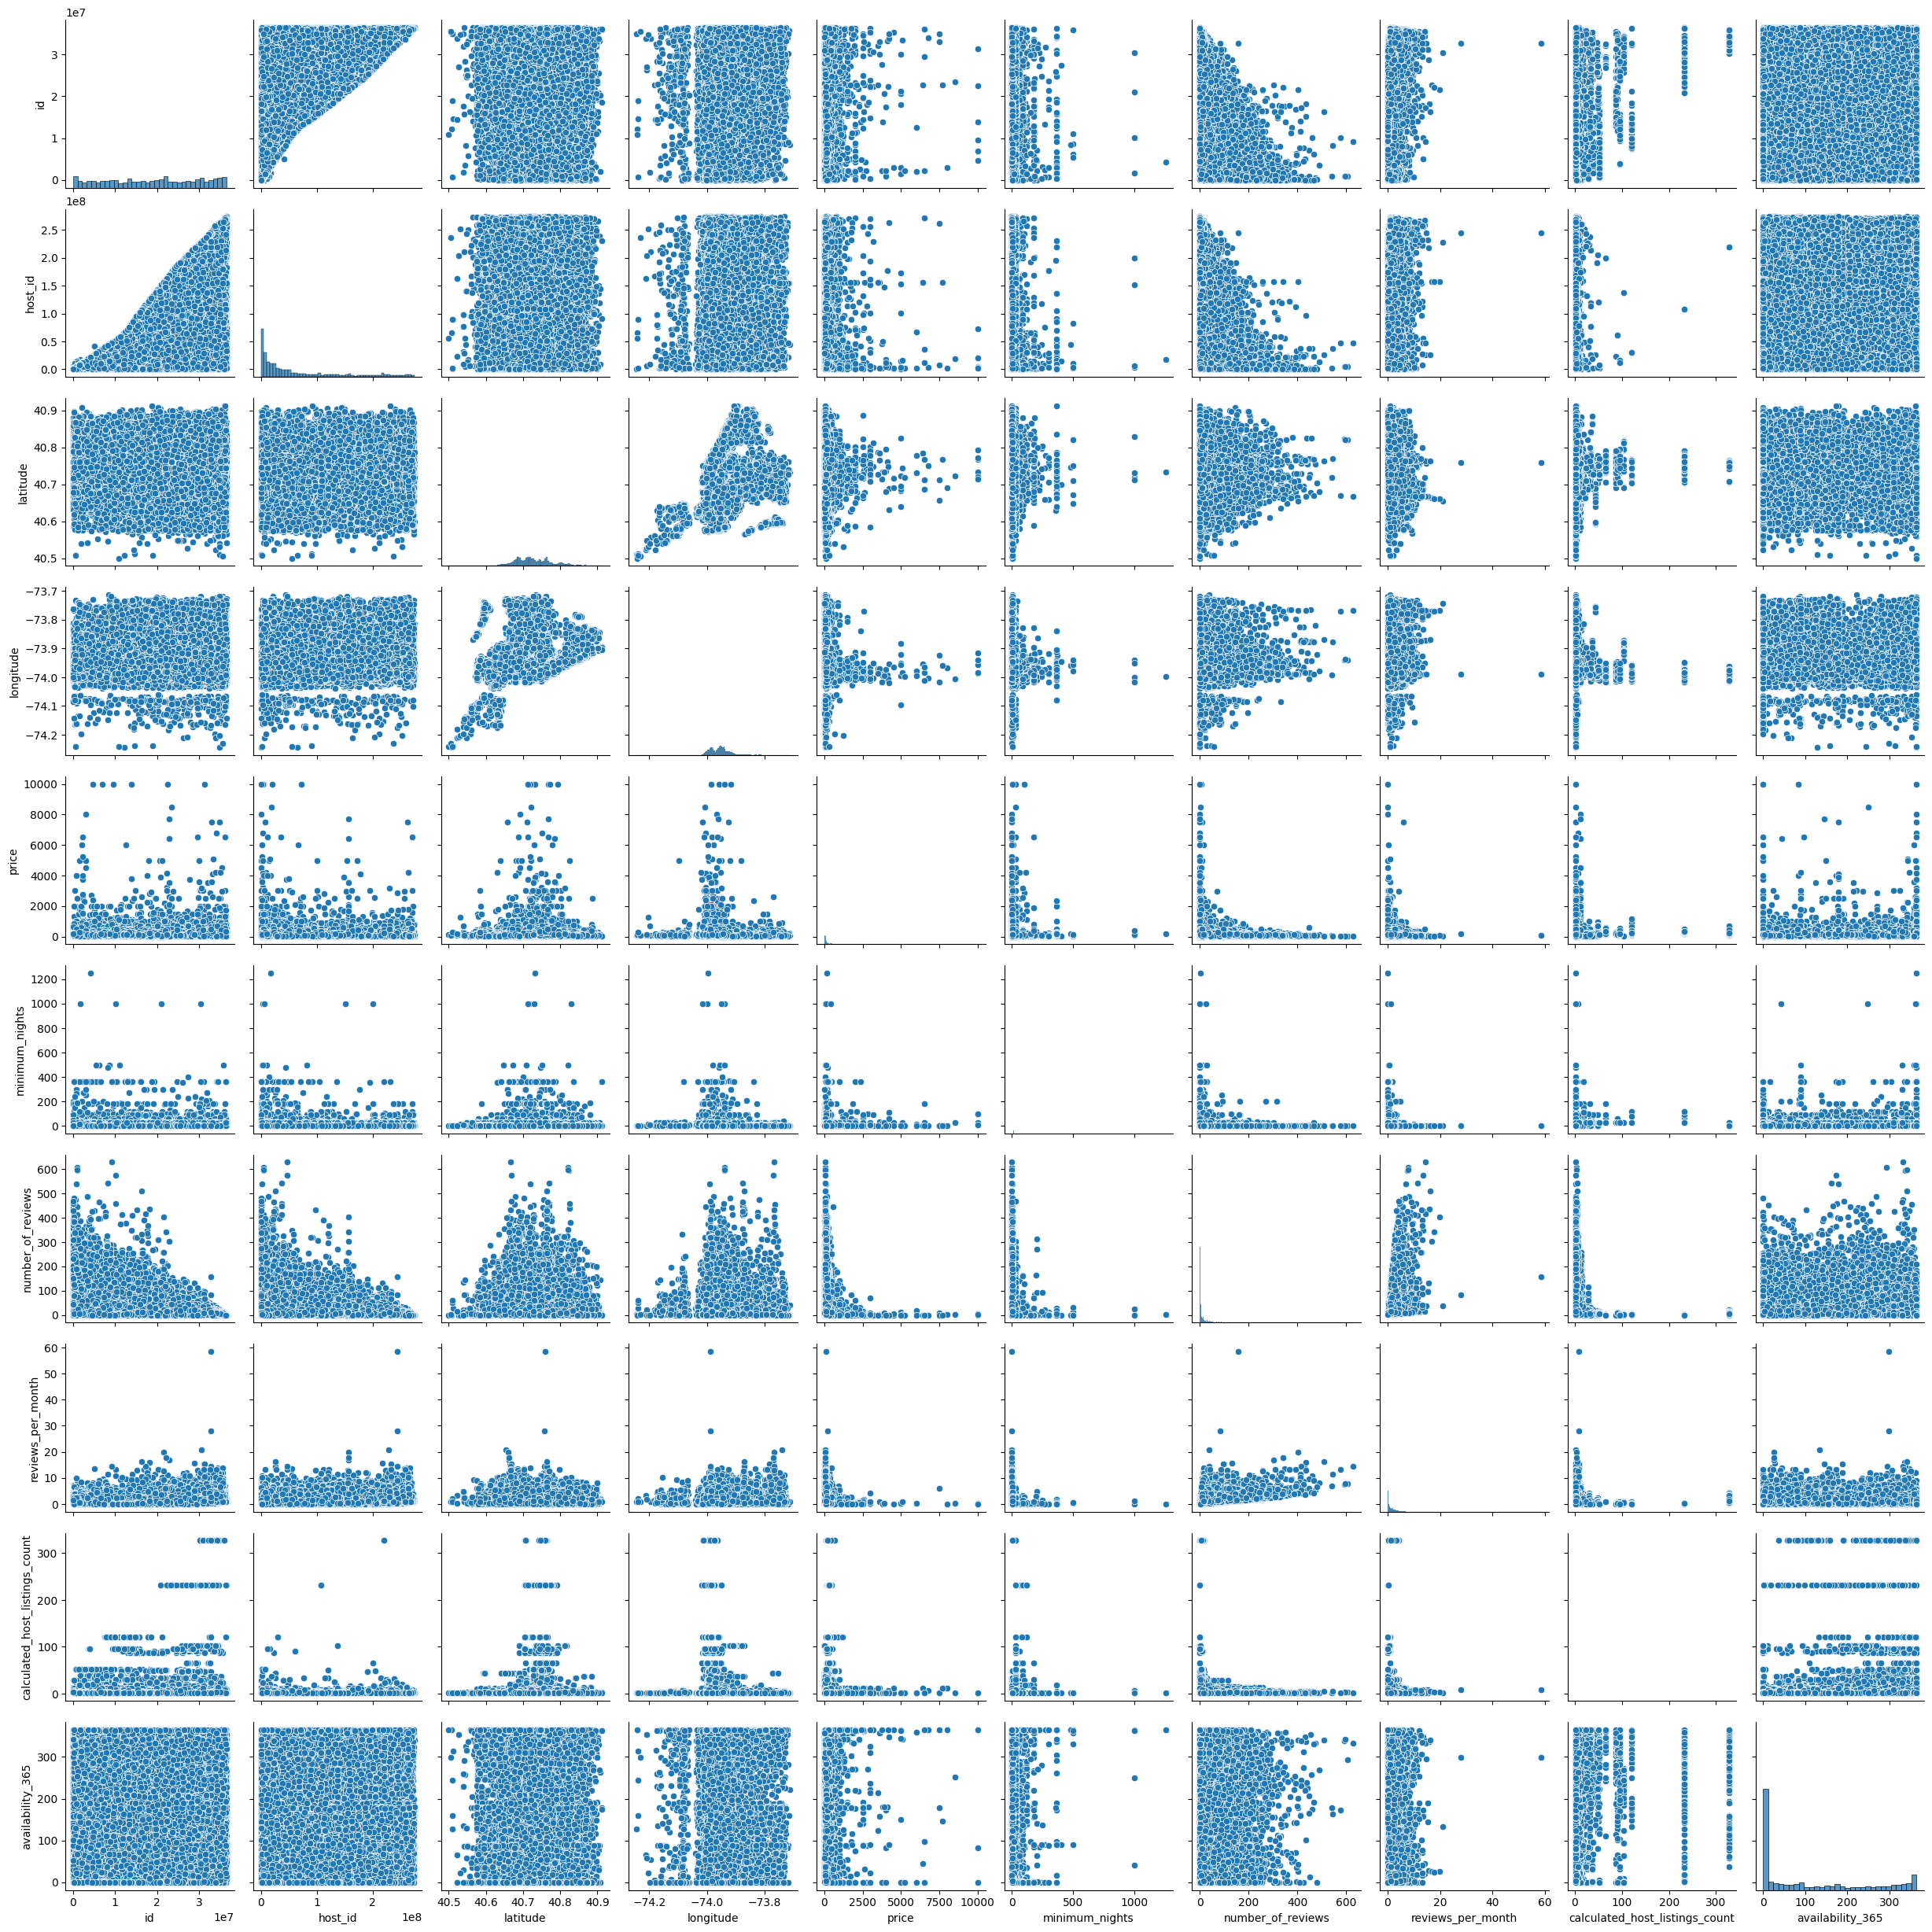

In [5]:
# Plot pairwise relationships in the dataset
sns.pairplot(data)
plt.show()

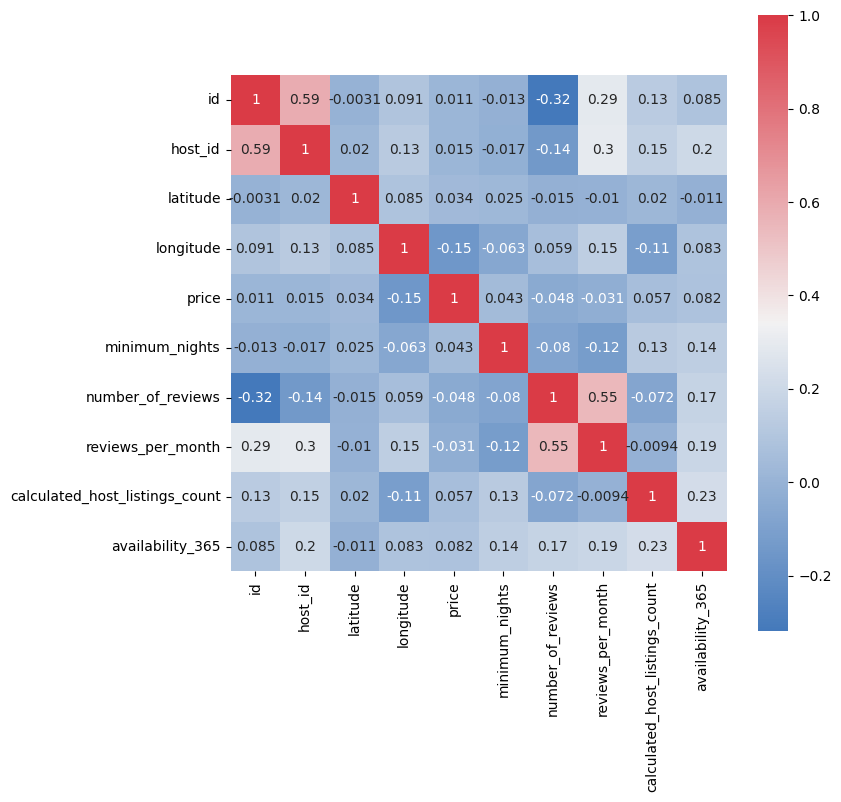

In [6]:
# Calculate and plot the correlation matrix of numeric features
numeric_data = data.select_dtypes(include=[float, int])
corr = numeric_data.corr()
cmap = sns.diverging_palette(250, 10, as_cmap=True)
plt.figure(figsize=(8, 8))
sns.heatmap(corr, square=True, cmap=cmap, annot=True)
plt.show()

#### TensorFlow Machine Learning Approaches

In [7]:
# Define a simple linear model class -- Included for practice ONLY. Can delete for actual deployment. Use ANN instead
class LinearModel:
    def __init__(self):
        # Initialize weight (W) and bias (b) with GlorotUniform initializer
        self.initializer = tf.keras.initializers.GlorotUniform()

    def loss(self, y, y_pred):
        # Compute mean absolute error loss
        return tf.reduce_mean(tf.abs(y - y_pred))
    
    def train(self, X, y, lr=0.000001, epochs=20, verbose=True):
        X = np.asarray(X, dtype=np.float32)  # Convert X to float32 numpy array
        y = np.asarray(y, dtype=np.float32).reshape((-1, 1))  # Reshape y to column vector

        # Initialize weight (W) and bias (b) with the GlorotUniform initializer
        self.W = tf.Variable(
            initial_value=self.initializer(shape=(X.shape[1], 1), dtype='float32')  # Weight matrix shape: [n_features, 1]
        )

        self.b = tf.Variable(
            initial_value=self.initializer(shape=(1,), dtype='float32')  # Bias term shape: [1]
        )
        
        # Define the training step function
        def train_step():
            with tf.GradientTape() as t:
                current_loss = self.loss(y, self.predict(X))  # Compute the current loss

            # Compute gradients of loss with respect to W and b
            dW, db = t.gradient(current_loss, [self.W, self.b])
            
            # Update weight and bias using the computed gradients
            self.W.assign_sub(lr * dW)  # W -= lr * dW
            self.b.assign_sub(lr * db)  # b -= lr * db

            return current_loss
                
        # Perform training over the specified number of epochs
        for epoch in range(epochs):
            current_loss = train_step()  # Perform one training step
            if verbose:
                # Print loss every epoch
                print(f'Epoch: {epoch}. Loss: {current_loss.numpy()}')  # Print loss with eager execution

    def predict(self, X):
        # Predict y values based on input X using the linear model
        # X is [n_instances, n_features], W is [n_features, 1]
        return tf.matmul(X, self.W) + self.b

In [8]:
# Initialize and train the custom linear model
model_test = LinearModel()
model_test.train(X_train, y_train, epochs=100)

Epoch: 0. Loss: 146.1902618408203
Epoch: 1. Loss: 146.17796325683594
Epoch: 2. Loss: 146.1656951904297
Epoch: 3. Loss: 146.1534423828125
Epoch: 4. Loss: 146.14117431640625
Epoch: 5. Loss: 146.12893676757812
Epoch: 6. Loss: 146.11671447753906
Epoch: 7. Loss: 146.10447692871094
Epoch: 8. Loss: 146.09226989746094
Epoch: 9. Loss: 146.08006286621094
Epoch: 10. Loss: 146.06785583496094
Epoch: 11. Loss: 146.0556640625
Epoch: 12. Loss: 146.04344177246094
Epoch: 13. Loss: 146.03125
Epoch: 14. Loss: 146.01904296875
Epoch: 15. Loss: 146.0068359375
Epoch: 16. Loss: 145.99465942382812
Epoch: 17. Loss: 145.9824676513672
Epoch: 18. Loss: 145.9702911376953
Epoch: 19. Loss: 145.95809936523438
Epoch: 20. Loss: 145.9459228515625
Epoch: 21. Loss: 145.93373107910156
Epoch: 22. Loss: 145.9215850830078
Epoch: 23. Loss: 145.909423828125
Epoch: 24. Loss: 145.8972625732422
Epoch: 25. Loss: 145.8850860595703
Epoch: 26. Loss: 145.87294006347656
Epoch: 27. Loss: 145.86077880859375
Epoch: 28. Loss: 145.8486328125
E

#### Multi Layer Perceptron (Artificial Neural Network)


In [9]:
# Define and compile the Keras model
model = tf.keras.models.Sequential([
    tf.keras.layers.Dense(128, activation='relu'), # 0 or x: _____/
    tf.keras.layers.Dropout(0.2), #generalize to prevent overfitting
    tf.keras.layers.Dense(1)
])

# Define custom R-squared metric
def R_squared(y_true, y_pred):
    residual = tf.reduce_sum(tf.square(y_true - y_pred))
    total = tf.reduce_sum(tf.square(y_true - tf.reduce_mean(y_true)))
    r2 = 1.0 - residual / total
    return r2

# Compile the Keras model with Adam optimizer and Mean Absolute Error loss function
adam_optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanAbsoluteError()

model.compile(
    optimizer=adam_optimizer,
    loss=loss_fn,
    metrics=[
        tf.keras.metrics.MeanAbsoluteError(),
        tf.keras.metrics.MeanSquaredError(),
        R_squared
    ]
)

In [10]:
# Convert training data to numpy arrays and ensure correct dtype
X_train = np.asarray(X_train, dtype=np.float32)
y_train = np.asarray(y_train, dtype=np.float32)

In [11]:
# Print the number of features
print(len(X_train[0]))

# Fit the Keras model on the training data
# model.fit(X_train, y_train, epochs=20)
model.fit(X_train, y_train, epochs=40, validation_split=0.2)

# Save the trained model to a file
model.save('models/air-bnb.h5') 

11
Epoch 1/40
856/856 ━━━━━━━━━━━━━━━━━━━━ 2s 2ms/step - loss: 112.8570 - mean_absolute_error: 112.8570 - mean_squared_error: 64946.1953 - r_squared: -60.0350 - val_loss: 88.3345 - val_mean_absolute_error: 88.3345 - val_mean_squared_error: 40501.1836 - val_r_squared: -45.4635
Epoch 2/40
856/856 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 92.0922 - mean_absolute_error: 92.0922 - mean_squared_error: 61481.6289 - r_squared: -43.6511 - val_loss: 71.8836 - val_mean_absolute_error: 71.8836 - val_mean_squared_error: 35157.9609 - val_r_squared: -37.1757
Epoch 3/40
856/856 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 75.7453 - mean_absolute_error: 75.7453 - mean_squared_error: 61693.0938 - r_squared: -38.5804 - val_loss: 62.3864 - val_mean_absolute_error: 62.3864 - val_mean_squared_error: 32702.7441 - val_r_squared: -37.7502
Epoch 4/40
856/856 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step - loss: 70.0845 - mean_absolute_error: 70.0845 - mean_squared_error: 69965.6562 - r_squared: -39.3421 - val_loss: 60.3599 - val

In [12]:
# Convert testing data to numpy arrays and ensure correct dtype
X_test = np.asarray(X_test, dtype=np.float32)
y_test = np.asarray(y_test, dtype=np.float32)

In [13]:
# Load the model with the custom R_squared metric
loaded_model = tf.keras.models.load_model('models/air-bnb.h5', custom_objects={"R_squared": R_squared})

# Print the model summary to verify its structure
print(loaded_model.summary())

# Evaluate the model on the test data
loss, mae, mse, r2 = loaded_model.evaluate(X_test, y_test)

print(f"Test Loss: {loss}")
print(f"Test MAE: {mae}")
print(f"Test MSE: {mse}")
print(f"Test R2: {r2}")


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 128)            │         1,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,667 (6.52 KB)

 Trainable params: 1,665 (6.50 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 2 (12.00 B)

None
459/459 ━━━━━━━━━━━━━━━━━━━━ 1s 743us/step - loss: 64.4781 - mean_absolute_error: 64.4781 - mean_squared_error: 62490.0664 - r_squared: -41.4222
Test Loss: 64.4513168334961
Test MAE: 64.4513168334961
Test MSE: 64859.48046875
Test R2: -41.32478713989258


In [14]:
# Make predictions and compare with actual values
predictions = loaded_model.predict(X_test[:2])
print(f'Predictions:\n{predictions}')
print()
print(f'Actual values:\n{y_test[:2]}')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
Predictions:
[[162.49832]
 [274.262  ]]

Actual values:
[100. 650.]


#### Conclusions

* Sometimes the data set limits us WRT to results
* Data preprocessing and analysis is important - Tensorflow does not live in a bubble, it's a tool
* TF 2 simplifies many things: no more placeholders, eager execution, .numpy(), no more sessions, Keras has a bigger role
* ANNs are very sensitive to hyperparameter choice
* Running on GPU can help, but it's not a must